In [3]:
# Imports
import os
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split

# Loading the data
raw_data = load_files(os.getcwd() + r'/Data', shuffle=False)
files = raw_data['filenames']
targets = raw_data['target']

# Randomly dividing the whole data into training (66.67%) and testing (33.33%) data 
train_files, test_files, train_targets, test_targets = train_test_split(files, targets, test_size=1/3, random_state=191)

# Taking ~25% of the training data for validation
valid_files = train_files[300:]
valid_targets = train_targets[300:]

# Remaining data will be used for training the model
train_files = train_files[:300]
train_targets = train_targets[:300]

print('Total number of videos:', len(files))
print('\nNumber of videos in training data:', train_files.shape[0])
print('Number of videos in validation data:', valid_files.shape[0])
print('Number of videos in test data:', test_files.shape[0])

Total number of videos: 598

Number of videos in training data: 300
Number of videos in validation data: 98
Number of videos in test data: 200


In [4]:
print('The categorical labels are converted into integers.\nFollowing is the mapping - \n')
for label in zip(range(6), raw_data['target_names']):
    print(label)

The categorical labels are converted into integers.
Following is the mapping - 

(0, 'boxing')
(1, 'handclapping')
(2, 'handwaving')
(3, 'jogging')
(4, 'running')
(5, 'walking')


In [5]:
# Displaying the first 5 videos (paths) in the training data along with their labels
# (path of video, class label)
for pair in zip(train_files[:5], train_targets[:5]):
    print(pair)

('/home/siddharth/Smart city/Human-Activity-Recognition/Final_code/Data/walking/person05_walking_d4_uncomp.avi', 5)
('/home/siddharth/Smart city/Human-Activity-Recognition/Final_code/Data/walking/person22_walking_d1_uncomp.avi', 5)
('/home/siddharth/Smart city/Human-Activity-Recognition/Final_code/Data/handwaving/person15_handwaving_d4_uncomp.avi', 2)
('/home/siddharth/Smart city/Human-Activity-Recognition/Final_code/Data/handwaving/person11_handwaving_d4_uncomp.avi', 2)
('/home/siddharth/Smart city/Human-Activity-Recognition/Final_code/Data/boxing/person18_boxing_d3_uncomp.avi', 0)


In [8]:
!pip install sk-video
import numpy as np
from skvideo.io import FFmpegReader, ffprobe
from skvideo.utils import rgb2gray
from PIL import Image
from keras.preprocessing import image
from tqdm import tqdm


class Videos(object):

    def __init__(self, target_size=None, to_gray=True, max_frames=None,
                 extract_frames='middle', required_fps=None,
                 normalize_pixels=None):

        self.target_size = target_size
        self.to_gray = to_gray
        self.max_frames = max_frames
        self.extract_frames = extract_frames
        self.required_fps = required_fps
        self.normalize_pixels = normalize_pixels
        self.fps = None

    def read_videos(self, paths):
        """
        Parameters:
            paths (list): Required
                 A list of paths of the videos to be read

        Returns:
            Numpy.ndarray
                A 5-d tensor with shape (<No. of Videos>, <No. of frames>, <height>, <width>, <channels>)
        """

        list_of_videos = [
            self._read_video(path) for path in tqdm(paths)
        ]

        tensor = np.vstack(list_of_videos)

        if self.normalize_pixels != None:
            # Pixels are normalized for each video individually
            if (type(self.normalize_pixels) == tuple) and (len(self.normalize_pixels) == 2):
                base = self.normalize_pixels[0]
                r = self.normalize_pixels[1] - base
                min_ = np.min(tensor, axis=(1, 2, 3), keepdims=True)
                max_ = np.max(tensor, axis=(1, 2, 3), keepdims=True)
                return ((tensor.astype('float32') - min_) / (max_ - min_)) * r + base

            elif self.normalize_pixels == 'z-score':
                mean = np.mean(tensor, axis=(1, 2, 3), keepdims=True)
                std = np.std(tensor, axis=(1, 2, 3), keepdims=True)
                return (tensor.astype('float32') - mean) / std
            
            else:
                raise ValueError('Invalid value of \'normalize_pixels\'')

        return tensor

    def get_frame_count(self, paths):
        """
        Can be used to determine the value of `max_frames`

        Parameters:
            paths (list): Required
                 A list of paths of the videos to be read

        Returns:
            dict (python dictionary)
                For each video, the total number of frames in that video is stored in the dictionary.
        """

        frame_count = {}
        for path in paths:
            cap = FFmpegReader(filename=path)
            frame_count[path] = cap.inputframenum
            cap.close()

        return frame_count

    def _read_video(self, path):
        """
        Parameters:
            path (str): Required
                Path of the video to be read

        Returns:
            Numpy.ndarray
                A 5-d tensor with shape (1, <No. of frames>, <height>, <width>, <channels>)
        """

        cap = FFmpegReader(filename=path)
        list_of_frames = []
        self.fps = int(cap.inputfps)                  # Frame Rate

        for index, frame in enumerate(cap.nextFrame()):

            capture_frame = True
            if self.required_fps != None:
                is_valid = range(self.required_fps)
                capture_frame = (index % self.fps) in is_valid

            if capture_frame:

                if self.target_size is not None:
                    temp_image = image.array_to_img(frame)
                    frame = image.img_to_array(
                        temp_image.resize(
                            self.target_size,
                            Image.ANTIALIAS)).astype('uint8')

                # Shape of each frame -> (<height>, <width>, 3)
                list_of_frames.append(frame)

        temp_video = np.stack(list_of_frames)
        cap.close()

        if self.to_gray:
            temp_video = rgb2gray(temp_video)
                
        if self.max_frames is not None:
            temp_video = self._process_video(video=temp_video)

        return np.expand_dims(temp_video, axis=0)

    def _process_video(self, video):
        """
        Parameters:
            video (Numpy.ndarray):
                Shape = (<No. of frames>, <height>, <width>, <channels>)

                Video whose frames are to be extracted

        Returns:
            Numpy.ndarray
                A tensor (processed video) with shape (<`max_frames`>, <height>, <width>, <channels>)
        """

        total_frames = video.shape[0]
        if self.max_frames <= total_frames:

            if self.extract_frames == 'first':
                video = video[:self.max_frames]
            elif self.extract_frames == 'last':
                video = video[(total_frames - self.max_frames):]
            elif self.extract_frames == 'middle':
                # No. of frames to remove from the front
                front = ((total_frames - self.max_frames) // 2) + 1
                video = video[front:(front + self.max_frames)]
            else:
                raise ValueError('Invalid value of \'extract_frames\'')

        else:
            raise IndexError(
                'Required number of frames is greater than the total number of frames in the video')

        return video


     |████████████████████████████████| 2.3MB 3.4MB/s 


Using TensorFlow backend.


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


Shape of the sample data: (1, 515, 120, 160, 3)


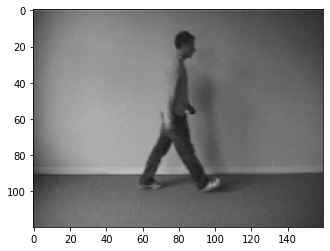

In [9]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


# The path of a sample video in the training data
sample_files = train_files[:1]

# An object of the class 'Videos'
reader = Videos(target_size=None, 
                to_gray=False)

# Loading the sample videos, in their original format
sample = reader.read_videos(sample_files)
print('\nShape of the sample data:', sample.shape)

# Displaying a frame from the sample video
plt.imshow(sample[0][300])

In [0]:
# Imports
import numpy as np
from keras.utils import to_categorical

# An object of the class `Videos` to load the data in the required format
reader = Videos(target_size=(128, 128), 
                to_gray=True, 
                max_frames=40, 
                extract_frames='first', 
                required_fps=5, 
                normalize_pixels=(-1, 1))

In [12]:
# Reading training videos and one-hot encoding the training labels
train_files1=train_files[:150]
train_files2=train_files[150:]
X_train1 = reader.read_videos(train_files1)
X_train2 = reader.read_videos(train_files2)
X_train = np.concatenate((X_train1,X_train2))
np.save('x_train.npy',X_train)
#X_train = np.load('x_trainl.npy')
y_train = to_categorical(train_targets, num_classes=6)
print('Shape of training data:', X_train.shape)
print('Shape of training labels:', y_train.shape)


100%|██████████| 150/150 [00:56<00:00,  2.65it/s]

100%|██████████| 150/150 [00:57<00:00,  2.60it/s]


Shape of training data: (300, 40, 128, 128, 1)
Shape of training labels: (300, 6)


In [13]:
# Reading validation videos and one-hot encoding the validation labels
X_valid = reader.read_videos(valid_files)
np.save('x_valid.npy',X_valid)
#X_valid = np.load('x_validl.npy')
y_valid = to_categorical(valid_targets, num_classes=6)
print('Shape of validation data:', X_valid.shape)
print('Shape of validation labels:', y_valid.shape)


100%|██████████| 98/98 [00:38<00:00,  2.53it/s]


Shape of validation data: (98, 40, 128, 128, 1)
Shape of validation labels: (98, 6)


In [14]:
# Reading testing videos and one-hot encoding the testing labels
X_test = reader.read_videos(test_files)
np.save('x_test.npy',X_test)
#X_test = np.load('x_testl.npy')
y_test = to_categorical(test_targets, num_classes=6)
print('Shape of testing data:', X_test.shape)
print('Shape of testing labels:', y_test.shape)


100%|██████████| 200/200 [01:18<00:00,  2.53it/s]


Shape of testing data: (200, 40, 128, 128, 1)
Shape of testing labels: (200, 6)


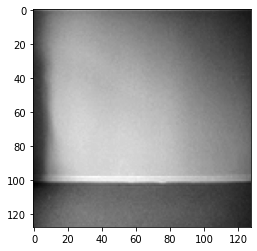

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

# After pre-processing

# Displaying the first frame of the first processed video from the training data
plt.imshow(np.squeeze(X_train[0][0], axis=2), cmap='gray')

In [17]:
# Imports
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D, BatchNormalization
from keras.layers.core import Dense, Dropout

# Using the Sequential Model
model = Sequential()

# Adding Alternate convolutional and pooling layers
model.add(Conv3D(filters=16, kernel_size=(5, 3, 3), strides=(1, 1, 1), padding='same', activation='relu', 
                 input_shape=X_train.shape[1:]))
model.add(MaxPooling3D(pool_size=2, strides=(2, 2, 2), padding='same'))

model.add(Conv3D(filters=64, kernel_size=(2, 3, 3), strides=(1, 1, 1), padding='valid', activation='relu'))
model.add(MaxPooling3D(pool_size=2, strides=(2, 2, 2), padding='same'))

model.add(Conv3D(filters=256, kernel_size=(2, 3, 3), strides=(1, 1, 1), padding='valid', activation='relu'))
model.add(MaxPooling3D(pool_size=2, strides=(2, 2, 2), padding='same'))

#model.add(Conv3D(filters=1024, kernel_size=(2, 3, 3), strides=(1, 1, 1), padding='valid', activation='relu'))
#model.add(MaxPooling3D(pool_size=2, strides=(2, 2, 2), padding='same'))

model.add(GlobalAveragePooling3D())

# Hidden layer
model.add(Dense(32, activation='relu'))

# Dropout Layer
model.add(Dropout(0.5))

# Output layer
model.add(Dense(6, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 40, 128, 128, 16)  736       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 20, 64, 64, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 19, 62, 62, 64)    18496     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 10, 31, 31, 64)    0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 9, 29, 29, 256)    295168    
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 5, 15, 15, 256)    0         
_________________________________________________________________
global_average_pooling3d_1 ( (None, 256)              

In [23]:
# Imports
#from keras.callbacks import ModelCheckpoint

# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

''' # Saving the model that performed the best on the validation set
checkpoint = ModelCheckpoint(filepath='Model_3.weights.best.hdf5', save_best_only=True, verbose=1)

# Training the model for 40 epochs
history = model.fit(X_train, y_train, batch_size=16, epochs=40, 
                    validation_data=(X_valid, y_valid), verbose=2, callbacks=[checkpoint]) '''

" # Saving the model that performed the best on the validation set\ncheckpoint = ModelCheckpoint(filepath='Model_3.weights.best.hdf5', save_best_only=True, verbose=1)\n\n# Training the model for 40 epochs\nhistory = model.fit(X_train, y_train, batch_size=16, epochs=40, \n                    validation_data=(X_valid, y_valid), verbose=2, callbacks=[checkpoint]) "

In [26]:
# Loading the model that performed the best on the validation set
model.load_weights('Model_3.weights.best.hdf5')

# Testing the model on the Test data
(loss, accuracy) = model.evaluate(X_test, y_test, batch_size=16, verbose=0)

print('Accuracy on test data: {:.2f}%'.format(accuracy * 100))

Accuracy on test data: 63.50%


In [77]:
# Making the plot larger
''' plt.figure(figsize=(12, 8))

loss = history.history['loss']                          # Loss on the training data
val_loss = history.history['val_loss']                  # Loss on the validation data
epochs = range(1, 41)

plt.plot(epochs, loss, 'ro-', label='Training Loss')
plt.plot(epochs, val_loss, 'go-', label = 'Validation Loss')
plt.legend() '''

" plt.figure(figsize=(12, 8))\n\nloss = history.history['loss']                          # Loss on the training data\nval_loss = history.history['val_loss']                  # Loss on the validation data\nepochs = range(1, 41)\n\nplt.plot(epochs, loss, 'ro-', label='Training Loss')\nplt.plot(epochs, val_loss, 'go-', label = 'Validation Loss')\nplt.legend() "

In [28]:
# Imports
import numpy as np
np.random.seed(141)

# Choosing 9 random persons (unique)
people = np.arange(1, 26)
chosen = np.random.choice(people, 9, replace=False)

print('The following people are chosen:', chosen)

# Selecting the paths of all the videos of these persons from our entire dataset
bench_files = []
indexes = []
for index in chosen:
    for i, path in enumerate(raw_data['filenames']):
        if (('person' + str(index)) in path) or (('person0' + str(index)) in path):
            bench_files.append(path)
            indexes.append(i)
            
bench_files = np.array(bench_files)
bench_targets = raw_data['target'][indexes]

The following people are chosen: [11 21 19 14 25 10 15  6  5]


In [0]:
# Imports
import numpy as np
from keras.utils import to_categorical

# An object of the class `Videos` to load the data in the required format
reader = Videos(target_size=(128, 128), 
                to_gray=True, 
                max_frames=40, 
                extract_frames='first', 
                required_fps=5, 
                normalize_pixels=(-1, 1))

In [30]:
bench_video = reader.read_videos(bench_files)
bench_target = to_categorical(bench_targets, num_classes=6)
print('Shape of training data:', bench_video.shape)
print('Shape of training labels:', bench_target.shape)


100%|██████████| 216/216 [01:30<00:00,  2.38it/s]


Shape of training data: (216, 40, 128, 128, 1)
Shape of training labels: (216, 6)


In [31]:
# Loading the model that performed the best on the validation set
model.load_weights('Model_3.weights.best.hdf5')

# Testing the model on the Test data
(loss, accuracy) = model.evaluate(bench_video, bench_target, batch_size=16, verbose=0)

print('Accuracy on test data: {:.2f}%'.format(accuracy * 100))

Accuracy on test data: 62.96%


In [0]:
# Changed the sequence of the classes
benchmark_cnf_matrix = [
    [0.979, 0.07, 0.07, 0.0, 0.0, 0.07], 
    [0.354, 0.597, 0.035, 0.0, 0.0, 0.014], 
    [0.208, 0.049, 0.736, 0.0, 0.0, 0.07], 
    [0.0, 0.0, 0.0, 0.604, 0.167, 0.229], 
    [0.0, 0.0, 0.0, 0.389, 0.549, 0.063], 
    [0.0, 0.0, 0.0, 0.162, 0.0, 0.838]
]

benchmark_cnf_matrix = np.array(benchmark_cnf_matrix)

In [0]:
import itertools
def confusion_matrix_plot(cm, classes, 
                          title='Normalized Confusion Matrix', 
                          normalize=False, 
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    plt.subplots(1, 1, figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

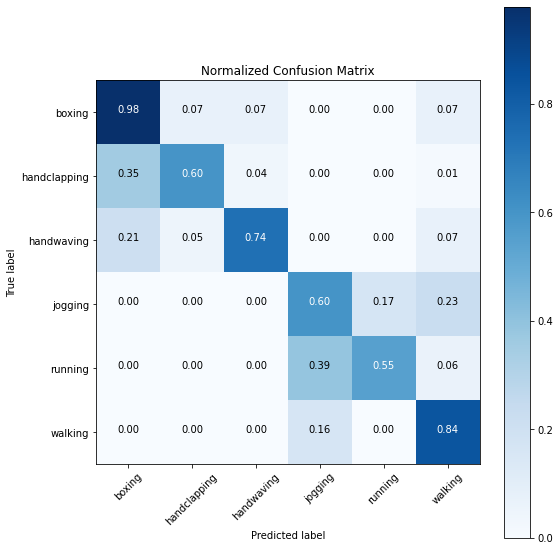

In [34]:
# Plotting the Confusion matrix of the Benchmark Model
confusion_matrix_plot(benchmark_cnf_matrix, 
                      classes=['boxing', 'handclapping', 'handwaving', 'jogging', 'running', 'walking'])

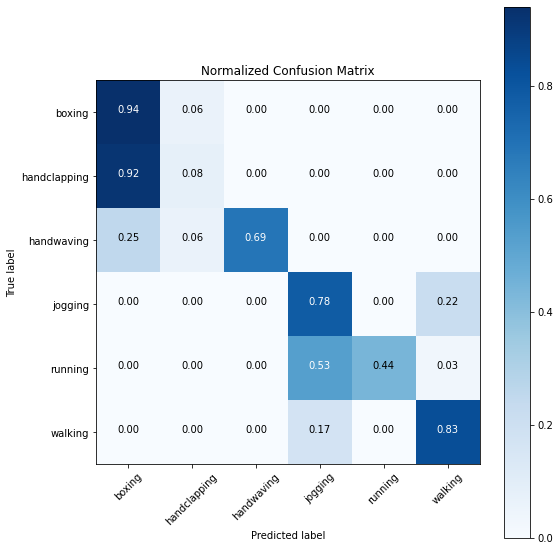

In [35]:
# Imports
from sklearn.metrics import confusion_matrix

# Getting the predictions of our Model
predictions = model.predict_classes(bench_video)

# Constructing the Confusion Matrix
model_cnf_matrix = confusion_matrix(bench_targets, predictions)

# PLotting the confusion matrix of our model
confusion_matrix_plot = confusion_matrix_plot(model_cnf_matrix, 
                                              classes=['boxing', 'handclapping', 'handwaving', 'jogging', 'running', 'walking'], 
                                              normalize=True)

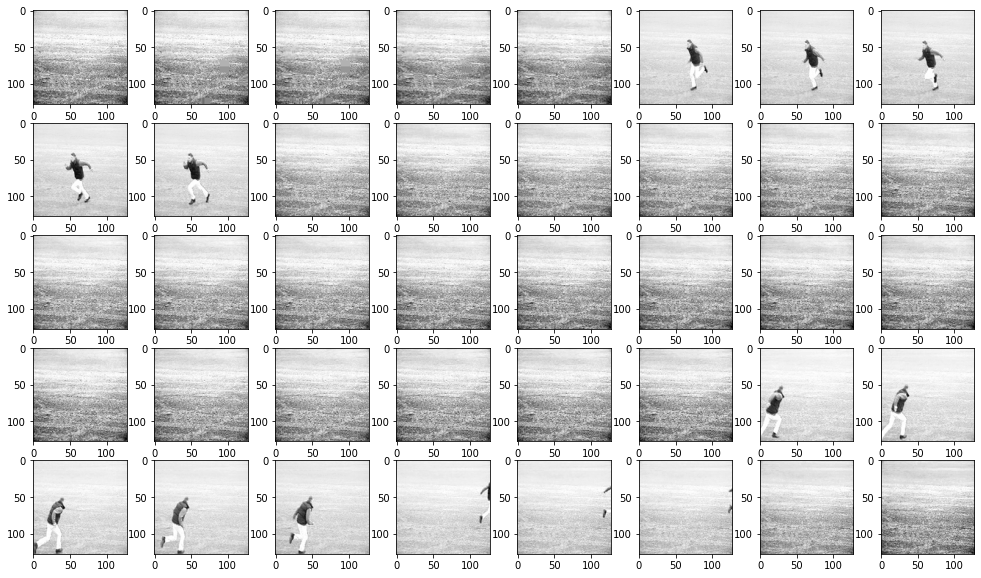

In [36]:
# Plotting the selected frames of a sample video (action being performed is running)

f, axarr = plt.subplots(5, 8, figsize=(17, 10))
row = 0
col = 0
for index, frame in enumerate(bench_video[17]):
    if index in [8, 16, 24, 32, 40]:
        row += 1
        col = 0
    axarr[row, col].imshow(np.squeeze(frame, axis=2), cmap='gray')
    col += 1

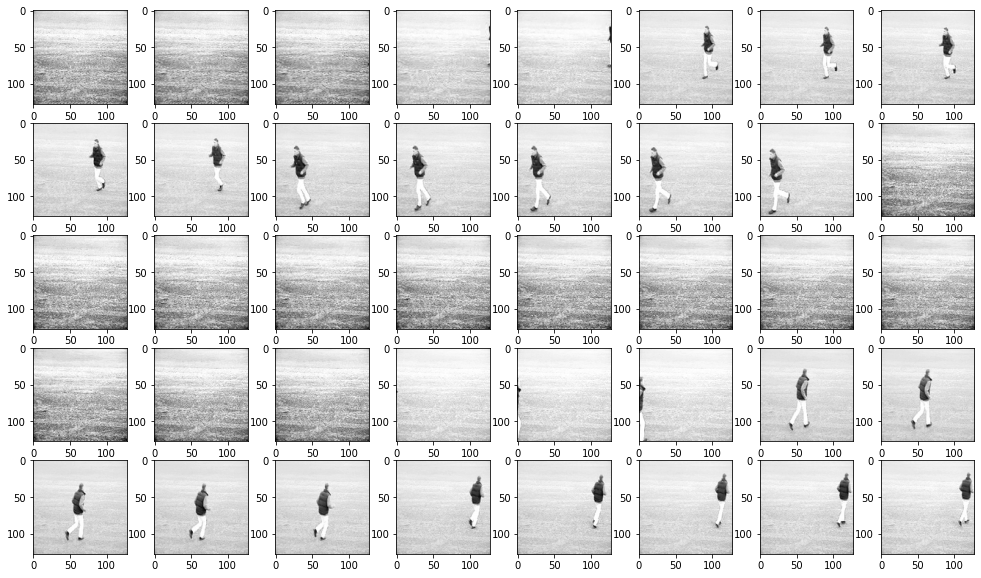

In [37]:
# Plotting the selected frames of a sample video (action being performed is jogging)

f, axarr = plt.subplots(5, 8, figsize=(17, 10))
row = 0
col = 0
for index, frame in enumerate(bench_video[13]):
    if index in [8, 16, 24, 32, 40]:
        row += 1
        col = 0
    axarr[row, col].imshow(np.squeeze(frame, axis=2), cmap='gray')
    col += 1

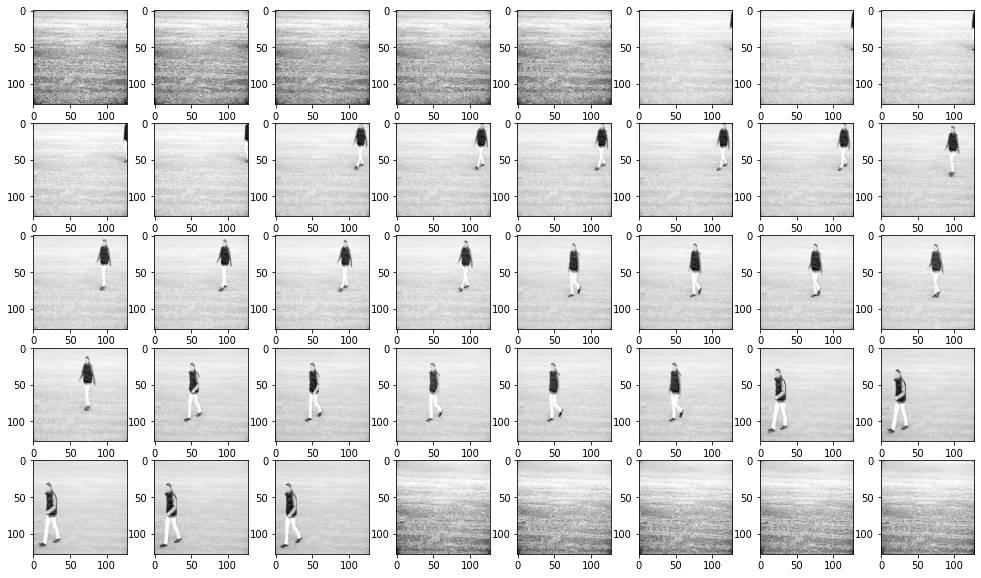

In [38]:
# Plotting the selected frames of a sample video (action being performed is walking)

f, axarr = plt.subplots(5, 8, figsize=(17, 10))
row = 0
col = 0
for index, frame in enumerate(bench_video[21]):
    if index in [8, 16, 24, 32, 40]:
        row += 1
        col = 0
    axarr[row, col].imshow(np.squeeze(frame, axis=2), cmap='gray')
    col += 1

In [105]:
reader = Videos(target_size=(128, 128), 
                to_gray=True, 
                max_frames=40, 
                extract_frames='first', 
                required_fps=5, 
                normalize_pixels=(-1, 1))
arr=["boxing.avi","sample.mp4","jogging.avi"]
x=reader.read_videos(arr)










  0%|          | 0/3 [00:00<?, ?it/s]








 33%|███▎      | 1/3 [00:00<00:00,  2.32it/s]








 67%|██████▋   | 2/3 [00:03<00:01,  1.12s/it]








100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


In [107]:
classes=['boxing', 'handclapping', 'handwaving', 'jogging', 'running', 'walking']
y = model.predict(x)
# plt.imshow(np.squeeze(x[2][120], axis=2), cmap='gray')
for i in range (len(y)):

    print("In"+" video"+str(i+1)+" person is:"+classes[np.argmax(y[i])])

In video1 person is:boxing
In video2 person is:handclapping
In video3 person is:jogging
